<a href="https://colab.research.google.com/github/Phionanamugga/Thesis/blob/main/EDA_BERT_Quantisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA + Quantisation for BERT/DistilBERT (CPU-first, GPU optional)

This notebook reproduces a lightweight experiment suitable for a thesis case study:
- **Dataset**: GLUE SST-2 (binary sentiment) via `datasets`
- **Models**: `bert-base-uncased` and `distilbert-base-uncased`
- **EDA**: label distribution, sentence lengths, token lengths
- **Baselines**: FP32 inference on CPU
- **Quantisation**: Dynamic INT8 for Linear layers on CPU (`torch.quantization.quantize_dynamic`)
- **Optional**: GPU timing if CUDA is available
- **Outputs**: results table (`results.csv`) and figures in `figures/`

> Run end-to-end on a laptop. No training required.


In [ ]:

!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers datasets accelerate psutil codecarbon
# bitsandbytes is optional (GPU 8-bit), not needed for CPU dynamic quantisation
!pip install -U bitsandbytes


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psut

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 7.8 MB/s eta 0:00:00
^C


In [1]:
import os, time, math, gc, json, psutil, tempfile, numpy as np
import torch
from torch import nn
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import matplotlib.pyplot as plt

os.makedirs('figures', exist_ok=True)
RESULTS_CSV = 'results.csv'

def human_size(num_bytes):
    units = ['B','KB','MB','GB']
    size = float(num_bytes)
    i = 0
    while size >= 1024 and i < len(units)-1:
        size /= 1024.0
        i += 1
    return f"{size:.2f} {units[i]}"

def rss_memory_gb():
    return psutil.Process().memory_info().rss / (1024**3)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda') if torch.cuda.is_available() else None
print("CUDA available:", torch.cuda.is_available())


CUDA available: False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
}) Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 872
})
Label names: ['negative', 'positive']


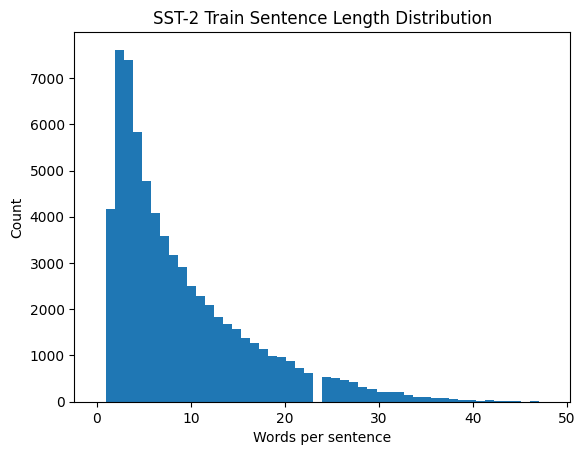

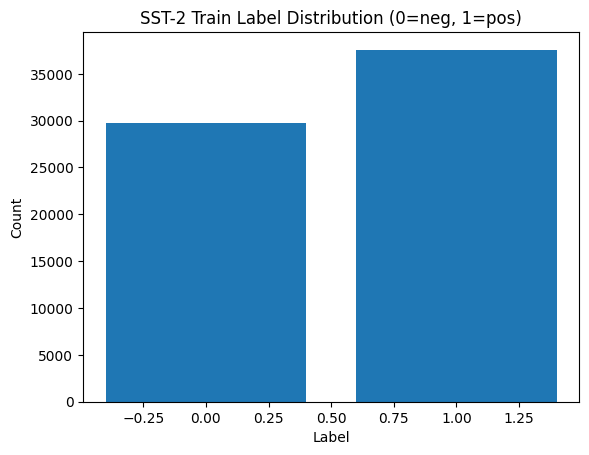

In [2]:
# Load SST-2 validation set for quick evaluation
ds = load_dataset('glue', 'sst2')
train_ds = ds['train']
val_ds = ds['validation']

print(train_ds, val_ds)
print("Label names:", ds['train'].features['label'].names)

# Quick EDA: sentence lengths
import re
def count_words(s): return len(re.findall(r"\w+", s))

train_lengths = [count_words(x) for x in train_ds['sentence']]
val_lengths   = [count_words(x) for x in val_ds['sentence']]

# Plot length distribution (train)
plt.figure()
plt.hist(train_lengths, bins=50)
plt.title("SST-2 Train Sentence Length Distribution")
plt.xlabel("Words per sentence")
plt.ylabel("Count")
plt.savefig('figures/sst2_train_length_hist.png', bbox_inches='tight')
plt.show()

# Label distribution
from collections import Counter
train_label_counts = Counter(train_ds['label'])
plt.figure()
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title("SST-2 Train Label Distribution (0=neg, 1=pos)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.savefig('figures/sst2_train_label_hist.png', bbox_inches='tight')
plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

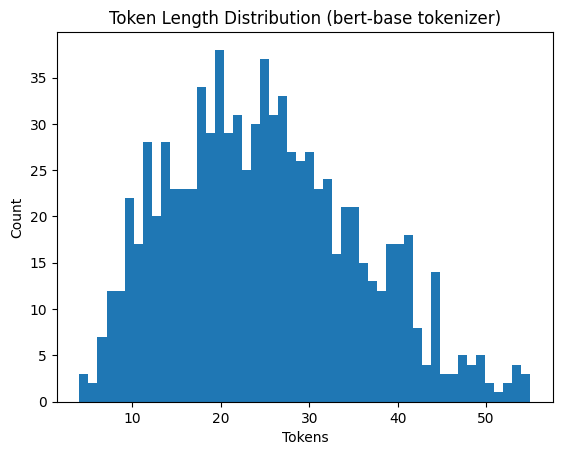

In [3]:
model_names = ['bert-base-uncased', 'distilbert-base-uncased']

def prep_dataset(model_name, split='validation'):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def tok(batch):
        return tokenizer(batch['sentence'], truncation=True)
    enc = ds[split].map(tok, batched=True)
    enc = enc.remove_columns([c for c in enc.column_names if c not in ['input_ids','attention_mask','label']])
    collate = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=None, return_tensors='pt')
    return tokenizer, enc, collate

# Token length distribution (for one tokenizer as proxy)
tok0, enc_val, collate0 = prep_dataset(model_names[0], split='validation')
token_lengths = [len(ids) for ids in enc_val['input_ids']]
plt.figure()
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution (bert-base tokenizer)")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.savefig('figures/sst2_val_token_length_hist.png', bbox_inches='tight')
plt.show()


In [4]:
from torch.utils.data import DataLoader

def evaluate_model(model, tokenizer, enc_dataset, collator, batch_size=32, device=torch.device('cpu'), warmup_batches=3):
    model.to(device)
    model.eval()
    loader = DataLoader(enc_dataset, batch_size=batch_size, shuffle=False, collate_fn=collator)
    correct = 0
    total = 0
    latencies = []
    with torch.no_grad():
        # Warmup
        for i, batch in enumerate(loader):
            if i >= warmup_batches: break
            batch = {k: v.to(device) for k,v in batch.items()}
            _ = model(**{k: v for k,v in batch.items() if k != 'labels'}) if 'labels' in batch else model(**batch)
        # Timed pass
        for batch in loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            inputs = {k: v for k,v in batch.items() if k != 'labels'}
            t0 = time.perf_counter()
            out = model(**inputs)
            t1 = time.perf_counter()
            latencies.append(t1 - t0)  # batch latency (seconds)
            preds = out.logits.argmax(dim=-1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            correct += (preds == labels).sum()
            total += labels.size
    acc = correct / total
    latency_per_ex = (np.sum(latencies) / total)  # seconds per example
    return acc, latency_per_ex, np.array(latencies)

def model_num_params(model):
    return sum(p.numel() for p in model.parameters())

def temp_model_size_bytes(model):
    # Save state dict to temp file to estimate on-disk size
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size = os.path.getsize(tmp.name)
    os.remove(tmp.name)
    return size


In [5]:
import pandas as pd

results = []

for mname in model_names:
    print("\n=== Loading model:", mname, "===")
    tokenizer, enc_val_m, collator = prep_dataset(mname, split='validation')
    model_fp32 = AutoModelForSequenceClassification.from_pretrained(mname, num_labels=2)

    # FP32 CPU
    start_mem = rss_memory_gb()
    acc, lat_per_ex, lats = evaluate_model(model_fp32, tokenizer, enc_val_m, collator, batch_size=32, device=device_cpu)
    mem_gb = rss_memory_gb()
    params = model_num_params(model_fp32)
    size_bytes = temp_model_size_bytes(model_fp32)
    results.append({
        'model': mname,
        'variant': 'FP32 CPU',
        'accuracy': acc,
        'latency_s_per_example': lat_per_ex,
        'params_million': params/1e6,
        'state_dict_size': human_size(size_bytes),
        'rss_mem_gb_post': round(mem_gb, 3)
    })
    del lats; gc.collect()

    # Dynamic INT8 quantisation (CPU)
    qmodel = torch.quantization.quantize_dynamic(model_fp32, {nn.Linear}, dtype=torch.qint8)
    acc_q, lat_per_ex_q, lats_q = evaluate_model(qmodel, tokenizer, enc_val_m, collator, batch_size=32, device=device_cpu)
    size_bytes_q = temp_model_size_bytes(qmodel)
    results.append({
        'model': mname,
        'variant': 'INT8 dynamic (CPU)',
        'accuracy': acc_q,
        'latency_s_per_example': lat_per_ex_q,
        'params_million': model_num_params(qmodel)/1e6,
        'state_dict_size': human_size(size_bytes_q),
        'rss_mem_gb_post': round(rss_memory_gb(), 3)
    })
    del qmodel, model_fp32; gc.collect()

# Optional GPU timing (if available)
if device_gpu is not None:
    torch.cuda.empty_cache()
    for mname in model_names:
        tokenizer, enc_val_m, collator = prep_dataset(mname, split='validation')
        model_gpu = AutoModelForSequenceClassification.from_pretrained(mname, num_labels=2).to(device_gpu)
        acc_g, lat_per_ex_g, lats_g = evaluate_model(model_gpu, tokenizer, enc_val_m, collator, batch_size=64, device=device_gpu)
        results.append({
            'model': mname,
            'variant': 'FP16/FP32 GPU (auto)',
            'accuracy': acc_g,
            'latency_s_per_example': lat_per_ex_g,
            'params_million': model_num_params(model_gpu)/1e6,
            'state_dict_size': 'N/A',
            'rss_mem_gb_post': round(rss_memory_gb(), 3)
        })
        del model_gpu; torch.cuda.empty_cache(); gc.collect()

df = pd.DataFrame(results)
df.to_csv(RESULTS_CSV, index=False)
df



=== Loading model: bert-base-uncased ===


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-676856157.py:28: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details



=== Loading model: distilbert-base-uncased ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,model,variant,accuracy,latency_s_per_example,params_million,state_dict_size,rss_mem_gb_post
0,bert-base-uncased,FP32 CPU,0.509174,0.158100,109.483778,417.72 MB,2.011
1,bert-base-uncased,INT8 dynamic (CPU),0.509174,0.100257,23.874048,173.09 MB,2.422
2,distilbert-base-uncased,FP32 CPU,0.589450,0.068950,66.955010,255.45 MB,2.161
3,distilbert-base-uncased,INT8 dynamic (CPU),0.550459,0.048732,23.854080,132.29 MB,2.266


,model,variant,accuracy,latency_s_per_example,params_million,state_dict_size,rss_mem_gb_post
0,bert-base-uncased,FP32 CPU,0.509174,0.158100,109.483778,417.72 MB,2.011
1,bert-base-uncased,INT8 dynamic (CPU),0.509174,0.100257,23.874048,173.09 MB,2.422
2,distilbert-base-uncased,FP32 CPU,0.589450,0.068950,66.955010,255.45 MB,2.161
3,distilbert-base-uncased,INT8 dynamic (CPU),0.550459,0.048732,23.854080,132.29 MB,2.266


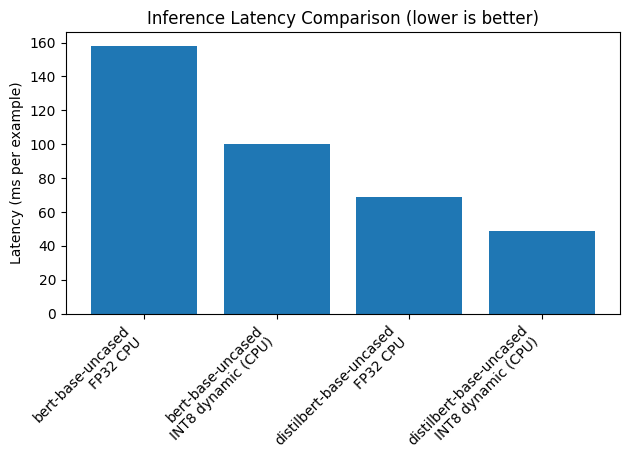

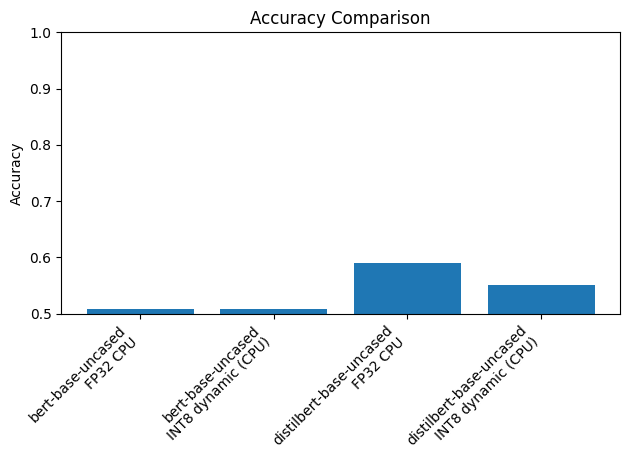

In [6]:
import pandas as pd
df = pd.read_csv('results.csv')
display(df)

# Convert to ms
df['latency_ms'] = df['latency_s_per_example'] * 1000.0

# Bar chart: latency by model/variant
plt.figure()
labels = [f"{m}\n{v}" for m,v in zip(df['model'], df['variant'])]
plt.bar(range(len(df)), df['latency_ms'])
plt.xticks(range(len(df)), labels, rotation=45, ha='right')
plt.ylabel("Latency (ms per example)")
plt.title("Inference Latency Comparison (lower is better)")
plt.tight_layout()
plt.savefig('figures/latency_bar.png', bbox_inches='tight')
plt.show()

# Bar chart: accuracy
plt.figure()
plt.bar(range(len(df)), df['accuracy'])
plt.xticks(range(len(df)), labels, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.title("Accuracy Comparison")
plt.tight_layout()
plt.savefig('figures/accuracy_bar.png', bbox_inches='tight')
plt.show()


## Methods (ready to paste in thesis)

**Models.** We evaluate `bert-base-uncased` and `distilbert-base-uncased` for sentiment classification on the GLUE SST-2 development set.  
**EDA.** We report sentence word counts, token length distributions, and label balance.  
**Baselines.** FP32 inference on CPU using Hugging Face Transformers.  
**Quantisation.** Dynamic post-training quantisation (`torch.quantization.quantize_dynamic`) on all `nn.Linear` layers (INT8 weights, FP32 accumulators).  
**Metrics.** Accuracy (argmax over logits), latency (seconds per example) averaged over the entire split, resident set size (RSS) as a proxy for host memory, and on-disk model state size.  
**Hardware/Runtime.** Laptop CPU; optional GPU timing when CUDA is available. Batch size is 32 on CPU and 64 on GPU for throughput stability.  
**Reproducibility.** We set a fixed random seed and use the public SST-2 split with no training.
